In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
import pickle5 as pickle
import pymatgen
import gzip

In [2]:
%config InlineBackend.figure_format='retina'


# Distance vs Energy plots

In [26]:
exp_dir_name_mapper = {
    'MoS2-plain-cv': 'MEGNet',
    'MoS2-plain-cv-catboost': 'Catboost+Matminer',
    'MoS2-plain-cv-gemnet': 'GemNet',
    'MoS2-plain-cv-schnet': 'SchNet',
}

exp_name_mapper = {
    'megnet-full.csv.gz': 'MEGNet',
    'megnet-sparse-z-werespecies.csv.gz': 'MEGNet-Sparse',
    'megnet-sparse-eos.csv.gz': 'MEGNet-Sparse-EOS',
    'catboost-test.csv.gz': 'Catboost+Matminer',
    'schnet-full.csv.gz': 'SchNet',
    'gemnet-full.csv.gz': 'GemNet',
    'megnet-sparse-eos-multitarget.csv.gz': "MEGNet-Sparse-EOS-Multi-target"

}


In [14]:
targets = pd.read_csv(Path('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/targets.csv.gz'), index_col=0)
folds = pd.read_csv(Path('../datasets/experiments/MoS2-plain-cv/folds.csv'), index_col=0)
targets.columns = pd.MultiIndex.from_product([['DFT'], targets.columns])
targets = targets.assign(folds=folds)


In [15]:
targets

DFT                                   \
                               energy energy_per_atom formation_energy   
_id                                                                      
6141cf0efbfd4bd9ab2c2f7e -1391.340414       -7.284505         2.645686   
6141cf0f51c1cbd9654b8870 -1384.552821       -7.287120         5.306279   
6141cf0fe689ecc4c43cdd4b -1397.196141       -7.277063         0.278959   
6141cf10b842c2e72e2f2d44 -1396.257593       -7.272175         0.579507   
6141cf1051c1cbd9654b8872 -1384.532677       -7.287014         5.326423   
...                               ...             ...              ...   
6148f3f63ac25c70a5c6cdff -1366.470166       -7.230001        12.455734   
6149087231cf3ef3d4a9f848 -1372.565892       -7.224031         9.849008   
6149c48031cf3ef3d4a9f84a -1372.237021       -7.222300        10.177879   
6149f3853ac25c70a5c6ce01 -1367.478625       -7.235337        11.447275   
615083823ac25c70a5c6ce03 -1367.169891       -7.233703        11.756009   

                                                                             \
                         formation_energy_per_site band_gap    homo    lumo   
_id                                                                           
6141cf0efbfd4bd9ab2c2f7e                  2.645686   1.1452 -0.6754  0.4698   
6141cf0f51c1cbd9654b8870                  2.653139   1.0843 -0.6852  0.3991   
6141cf0fe689ecc4c43cdd4b                  0.278959   1.8033 -0.6931  1.1102   
6141cf10b842c2e72e2f2d44                  0.289753   1.8095 -0.6916  1.1179   
6141cf1051c1cbd9654b8872                  2.663212   1.1102 -0.6718  0.4384   
...                                            ...      ...     ...     ...   
6148f3f63ac25c70a5c6cdff                  4.151911   0.3526 -0.5351 -0.1825   
6149087231cf3ef3d4a9f848                  3.283003   0.3002 -0.4501 -0.1499   
6149c48031cf3ef3d4a9f84a                  3.392626   0.3594 -0.5045 -0.1451   
6149f3853ac25c70a5c6ce01                  3.815758   0.5270 -0.6883 -0.1613   
615083823ac25c70a5c6ce03                  3.918670   0.4295 -0.6140 -0.1845   

                                     folds  
                         fermi_level        
_id                                         
6141cf0efbfd4bd9ab2c2f7e   -0.199707     2  
6141cf0f51c1cbd9654b8870   -0.220627     2  
6141cf0fe689ecc4c43cdd4b   -0.183537     3  
6141cf10b842c2e72e2f2d44   -0.179802     5  
6141cf1051c1cbd9654b8872   -0.213190     4  
...                              ...   ...  
6148f3f63ac25c70a5c6cdff   -0.359015     5  
6149087231cf3ef3d4a9f848   -0.300181     6  
6149c48031cf3ef3d4a9f84a   -0.324836     7  
6149f3853ac25c70a5c6ce01   -0.424306     7  
615083823ac25c70a5c6ce03   -0.398333     1  

[5933 rows x 9 columns]

In [16]:
structures = pd.read_pickle('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/data.pickle.gz')

In [55]:
predictions = Path('../datasets/predictions').resolve()
predictions = list(predictions.rglob('*.csv.gz'))
# Filter out other directories based on the mapper above
# file.parts[-3] correspond to directory name
predictions = list(filter(
    lambda file: file.parts[-3] in exp_dir_name_mapper.keys(),
    predictions
))

data = defaultdict(dict)
for file in predictions: 
    exp_name = exp_name_mapper.get(file.name)
    if exp_name == None:
        continue
    # target_name = target_name_mapper.get(file.parts[-2]) 
    target_name = file.parts[-2] 
    df = pd.read_csv(file, index_col=0)
    if exp_name == "MEGNet-Sparse-EOS-Multi-target":
        df.columns = ['formation_energy_per_site', 'homo']
        data[exp_name]['formation_energy_per_site'] = df.iloc[:, 0]
        data[exp_name]['homo'] = df.iloc[:, 1]

    else:
        data[exp_name][target_name] = df

def make_df_from_trial(data: dict, name: str):
    df = pd.concat(data, axis=1)
    try:
        df.columns = df.columns.droplevel(-1)
    except: pass
    # Append each attribute with _pred
    # df = df.add_suffix('_pred')
    # Add Higher level index (name of experiment)
    df.columns = pd.MultiIndex.from_product([[name], df.columns])
    return df

predictions = pd.concat([make_df_from_trial(v, k) for k, v in data.items()], axis=1)
# Concat with actual data
predictions = pd.concat([predictions, targets], axis=1)

# reindex with folds
predictions.index = pd.MultiIndex.from_arrays([predictions.index, targets.folds])
# drop folds column
predictions = predictions.drop('folds', level=0, axis=1)

In [56]:
predictions.loc[:, "MEGNet-Sparse-EOS-Multi-target"]

formation_energy_per_site      homo
_id                      folds                                     
6141cf0efbfd4bd9ab2c2f7e 2                       2.642563 -0.680672
6141cf0f51c1cbd9654b8870 2                       2.660528 -0.682423
6141cf0fe689ecc4c43cdd4b 3                       0.282107 -0.680286
6141cf10b842c2e72e2f2d44 5                       0.270441 -0.692672
6141cf1051c1cbd9654b8872 4                       2.673846 -0.669570
...                                                   ...       ...
6148f3f63ac25c70a5c6cdff 5                       4.143129 -0.535186
6149087231cf3ef3d4a9f848 6                       3.279012 -0.412578
6149c48031cf3ef3d4a9f84a 7                       3.354866 -0.524121
6149f3853ac25c70a5c6ce01 7                       3.893307 -0.599576
615083823ac25c70a5c6ce03 1                       3.820918 -0.583383

[5933 rows x 2 columns]

In [45]:
predictions

MEGNet                                      \
                                band_gap formation_energy_per_site      homo   
_id                      folds                                                 
6141cf0efbfd4bd9ab2c2f7e 2      1.007831                  2.770061 -0.667460   
6141cf0f51c1cbd9654b8870 2      0.995501                  2.735207 -0.670360   
6141cf0fe689ecc4c43cdd4b 3      1.796742                  1.799034 -0.682917   
6141cf10b842c2e72e2f2d44 5      0.917852                  0.314758 -0.694724   
6141cf1051c1cbd9654b8872 4      1.057544                  2.652418 -0.666106   
...                                  ...                       ...       ...   
6148f3f63ac25c70a5c6cdff 5      0.536790                  4.106874 -0.537053   
6149087231cf3ef3d4a9f848 6      0.289587                  3.284019 -0.430816   
6149c48031cf3ef3d4a9f84a 7      0.384984                  3.379792 -0.541001   
6149f3853ac25c70a5c6ce01 7      0.383230                  4.009428 -0.556664   
615083823ac25c70a5c6ce03 1      0.391067                  3.813787 -0.497973   

                               MEGNet-Sparse-EOS                            \
                                        band_gap formation_energy_per_site   
_id                      folds                                               
6141cf0efbfd4bd9ab2c2f7e 2                   0.0                  2.638975   
6141cf0f51c1cbd9654b8870 2                   0.0                  2.651181   
6141cf0fe689ecc4c43cdd4b 3                   0.0                  0.292739   
6141cf10b842c2e72e2f2d44 5                   0.0                  0.305600   
6141cf1051c1cbd9654b8872 4                   0.0                  2.663806   
...                                          ...                       ...   
6148f3f63ac25c70a5c6cdff 5                   0.0                  4.136736   
6149087231cf3ef3d4a9f848 6                   0.0                  3.277760   
6149c48031cf3ef3d4a9f84a 7                   0.0                  3.356987   
6149f3853ac25c70a5c6ce01 7                   0.0                  3.890929   
615083823ac25c70a5c6ce03 1                   0.0                  3.821268   

                                                   MEGNet-Sparse  \
                                    lumo      homo      band_gap   
_id                      folds                                     
6141cf0efbfd4bd9ab2c2f7e 2      0.444862 -0.677315      1.102549   
6141cf0f51c1cbd9654b8870 2      0.388985 -0.703089      1.044077   
6141cf0fe689ecc4c43cdd4b 3      1.120906 -0.693750      1.809166   
6141cf10b842c2e72e2f2d44 5      1.123136 -0.692421      1.805601   
6141cf1051c1cbd9654b8872 4      0.446301 -0.671909      1.123974   
...                                  ...       ...           ...   
6148f3f63ac25c70a5c6cdff 5     -0.175850 -0.525520      0.370546   
6149087231cf3ef3d4a9f848 6     -0.157851 -0.438995      0.283310   
6149c48031cf3ef3d4a9f84a 7     -0.138605 -0.502208      0.377617   
6149f3853ac25c70a5c6ce01 7     -0.169062 -0.584862      0.391503   
615083823ac25c70a5c6ce03 1     -0.144774 -0.514653      0.479726   

                                                                    ...  \
                               formation_energy_per_site      lumo  ...   
_id                      folds                                      ...   
6141cf0efbfd4bd9ab2c2f7e 2                      2.690059  0.420094  ...   
6141cf0f51c1cbd9654b8870 2                      2.680738  0.379825  ...   
6141cf0fe689ecc4c43cdd4b 3                      0.272740  1.114005  ...   
6141cf10b842c2e72e2f2d44 5                      0.298375  1.111286  ...   
6141cf1051c1cbd9654b8872 4                      2.669826  0.428279  ...   
...                                                  ...       ...  ...   
6148f3f63ac25c70a5c6cdff 5                      4.171951 -0.179644  ...   
6149087231cf3ef3d4a9f848 6                      3.294108 -0.151409  ...   
6149c48031cf3ef3d4a9f84a 7                

In [59]:
def defect2_distance(structures):
    d1, d2 = structures
    return d1.distance(d2)


def defect3_distance(structures):
    d1, d2, d3 = structures
    a = d1.distance(d2)
    b = d2.distance(d3)
    c = d1.distance(d3)

    d = np.sort(np.array([a, b, c]))
    v = np.array([1, 0.1, 0.01])

    return (d * v).sum()

def defect3_distance_2(structures):
    get_atom_of_type = lambda atom_type: [atom for atom in structures if atom.properties['was'] == atom_type]
    Mo = get_atom_of_type(42)[0]
    S1, S2 = get_atom_of_type(16)
    a = min([Mo.distance(S1), Mo.distance(S2)])
    b = max([Mo.distance(S1), Mo.distance(S2)])
    c = S1.distance(S2)

    d = np.array([a, b, c])
    v = np.array([1, 0.1, 0.01])
    return np.dot(d, v)

In [60]:
def defects_counter(sites):
    defects = defaultdict(int)
    for s in sites:
        defects[f'z_{s.properties["was"]}'] += 1
    return defects

def num_defects(structures):
    structures['num_defects'] = structures.defect_representation.apply(lambda item: len(item))
    return structures

def vacancy_defects(structures):
    structures['V'] = structures.defect_representation.apply(lambda sites: list(filter(lambda site: site.species_string == 'X0+', sites))) \
                                                      .apply(lambda sites: defects_counter(sites))

    structures = pd.concat([structures, structures.V.apply(pd.Series, dtype=object)], axis=1)
    return structures


def defects_distance_v2(structures):
    v2 = structures.query('z_16==1 and z_42==1 and num_defects==2')
    return pd.Series(v2['defect_representation'].apply(defect2_distance), name='distance')

def defects_distance_v3(structures):
    v3 = structures.query('z_16==2 and z_42==1 and num_defects==3')
    return pd.Series(v3['defect_representation'].apply(defect3_distance_2), name='distance')


In [61]:
v2 = defects_distance_v2(
    vacancy_defects(
        num_defects(
            structures
        )
    )
)

In [62]:
v3 = defects_distance_v3(
    vacancy_defects(
        num_defects(
            structures
        )
    )
)

In [63]:
def plot(d, e, legend, ax, color, alpha=0.5, **kwargs):
    args = np.argsort(d)
    ax.plot(d[args], e[args], '.', color=color, alpha=0.3, label=legend, mfc='white', **kwargs)

    ax.plot(d[args], e[args], alpha=alpha, color=color, zorder=-1)
    ax.legend(loc='lower right')
    return ax

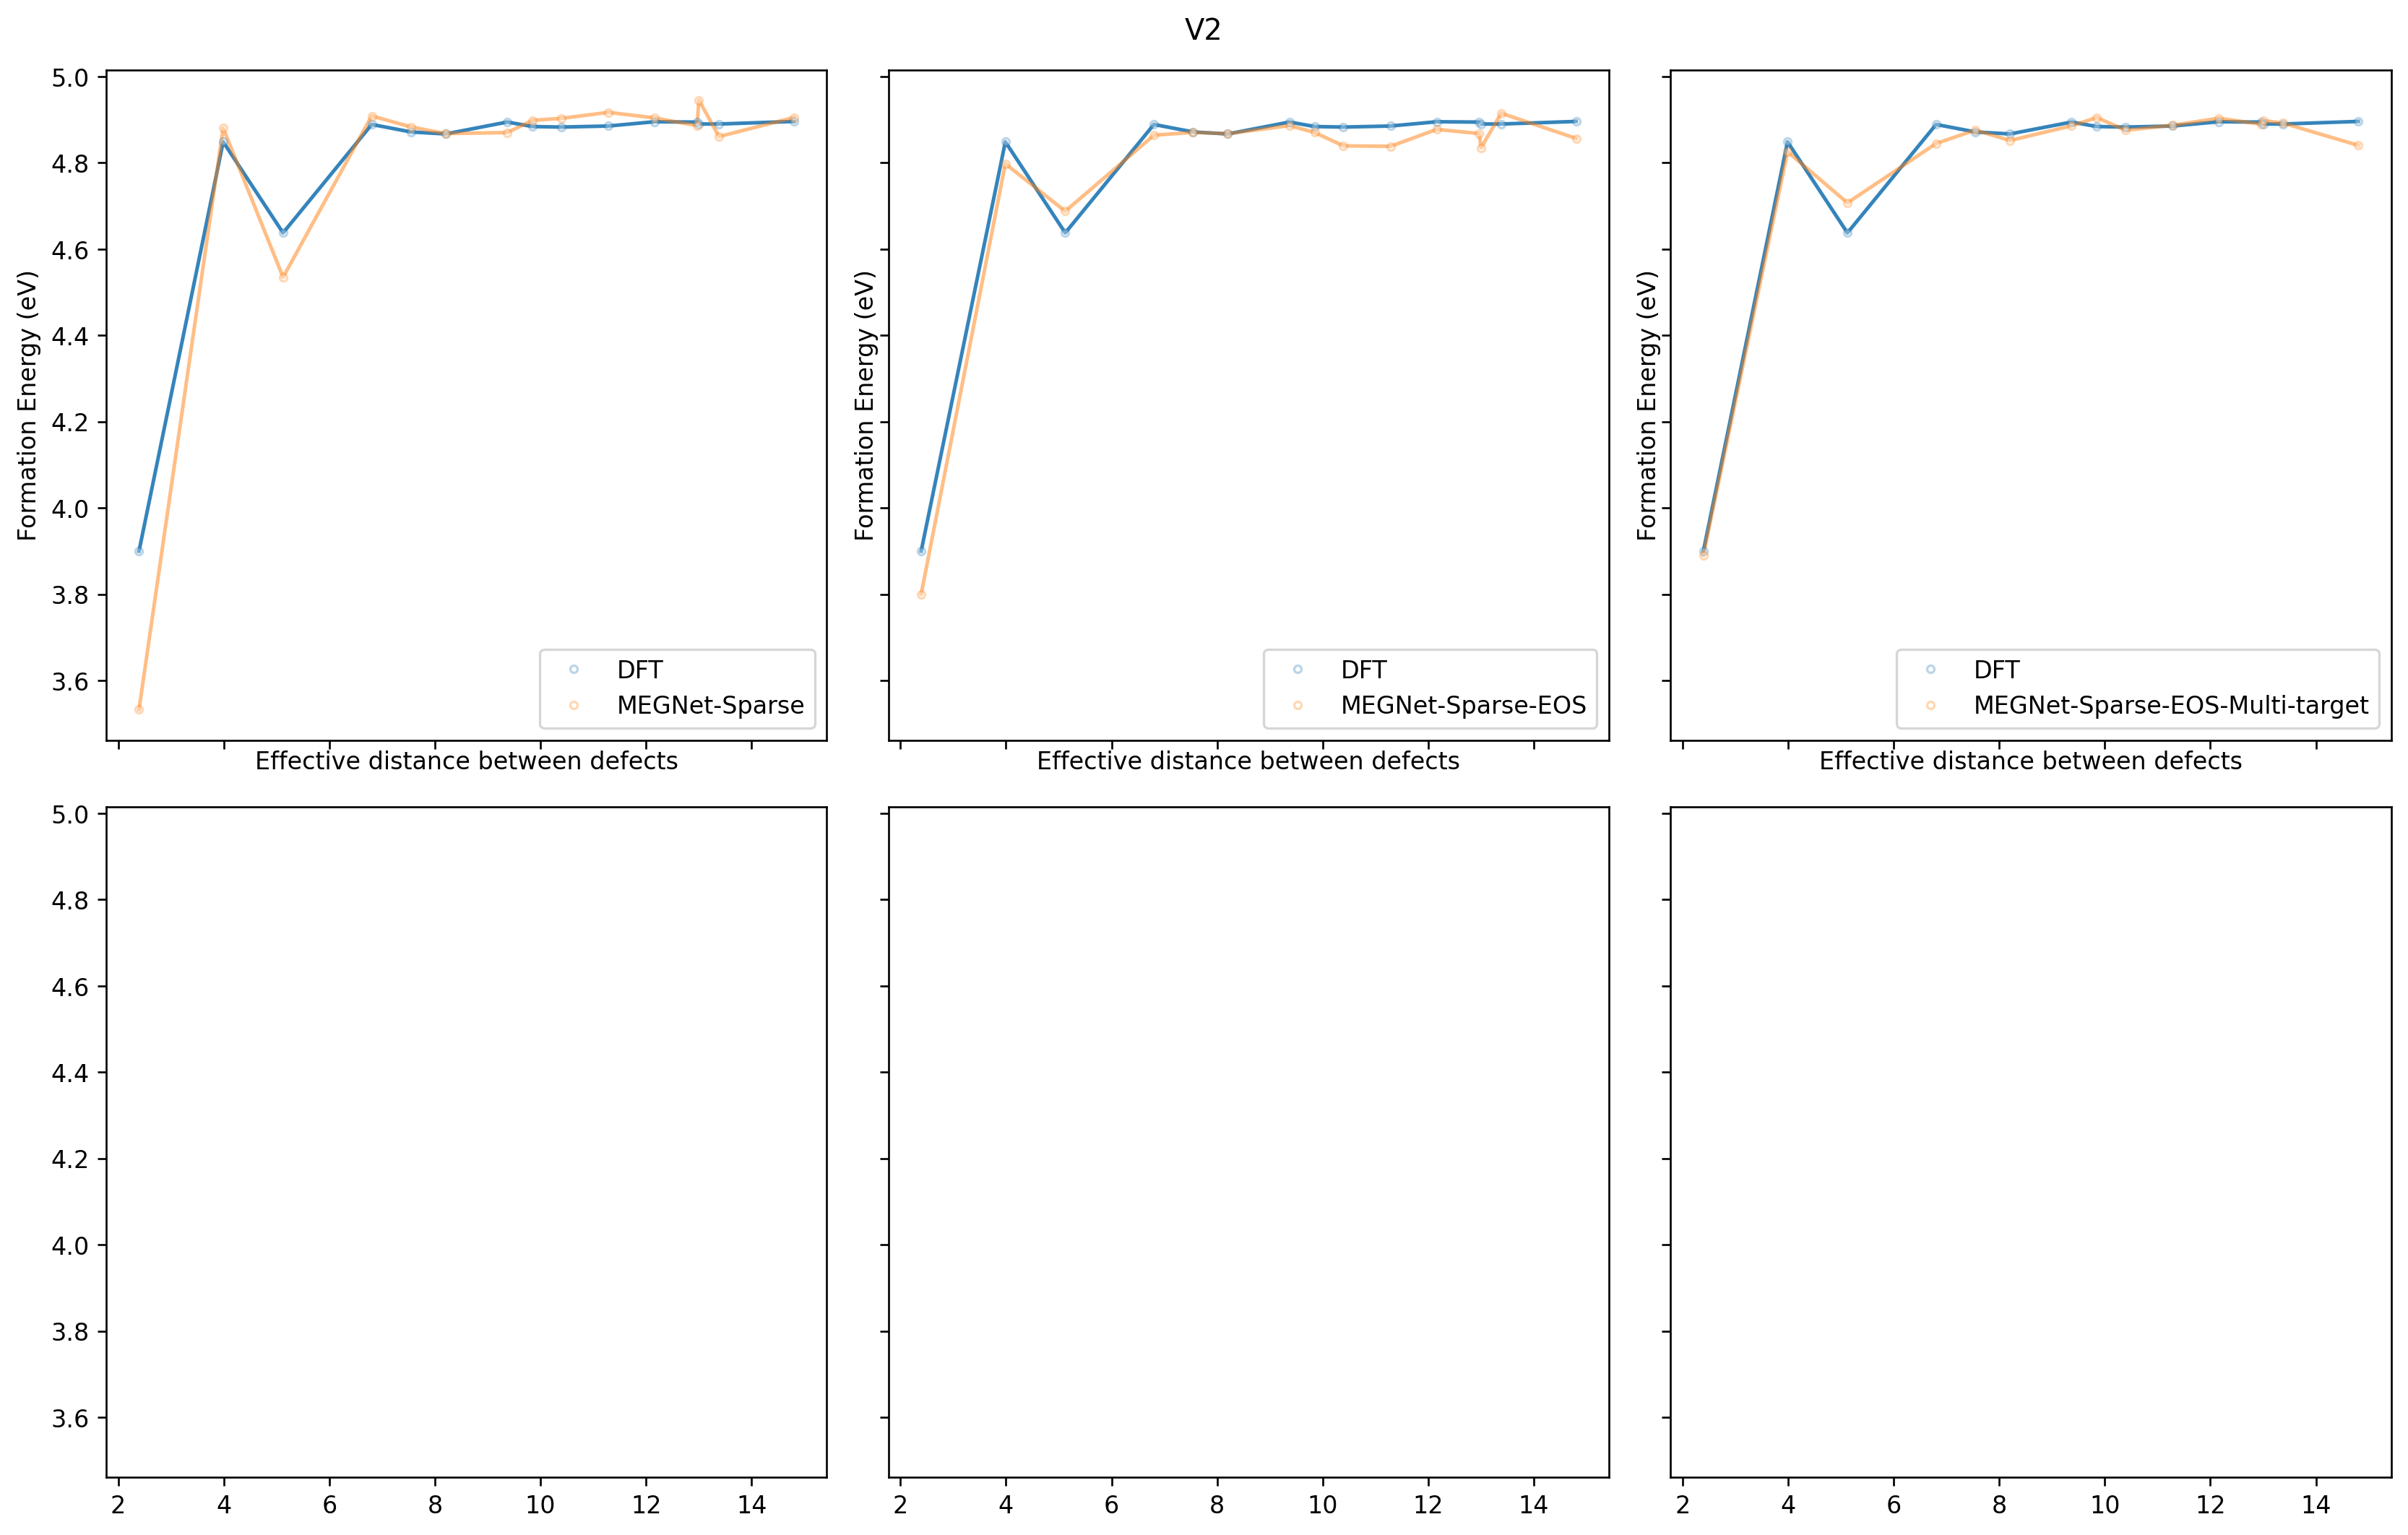

In [65]:
v2_groups, v2_dfs = list(map(list, zip(*predictions.groupby(level=0, axis=1))))
dft = predictions.loc[:, 'DFT'].loc[v2.index].droplevel(1).assign(v2=v2)
fig, axs = plt.subplots(2, 3, figsize=(14, 9), dpi=120, sharex=True, sharey=True)

for name, ax in zip(['MEGNet-Sparse', 'MEGNet-Sparse-EOS', 'MEGNet-Sparse-EOS-Multi-target'], axs.flatten()):
    
    colors = iter(cm.tab10(np.linspace(0, 1, 10)))
    
    pred = predictions.loc[:, name]
    # pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v2.index].droplevel(1).assign(v2=v2)

    for name, data in {'DFT': dft, name: pred}.items():
        plot(
            data.v2,
            data.formation_energy_per_site,
            legend=name,
            ax=ax,
            color=next(colors),
            alpha=0.9 if name == 'DFT' else 0.5,
        )

    ax.set_ylabel('Formation Energy (eV)'),
    ax.set_xlabel('Effective distance between defects')

fig.suptitle('V2')
fig.tight_layout()
fig.show()


Text(0.5, 1.0, 'V2')

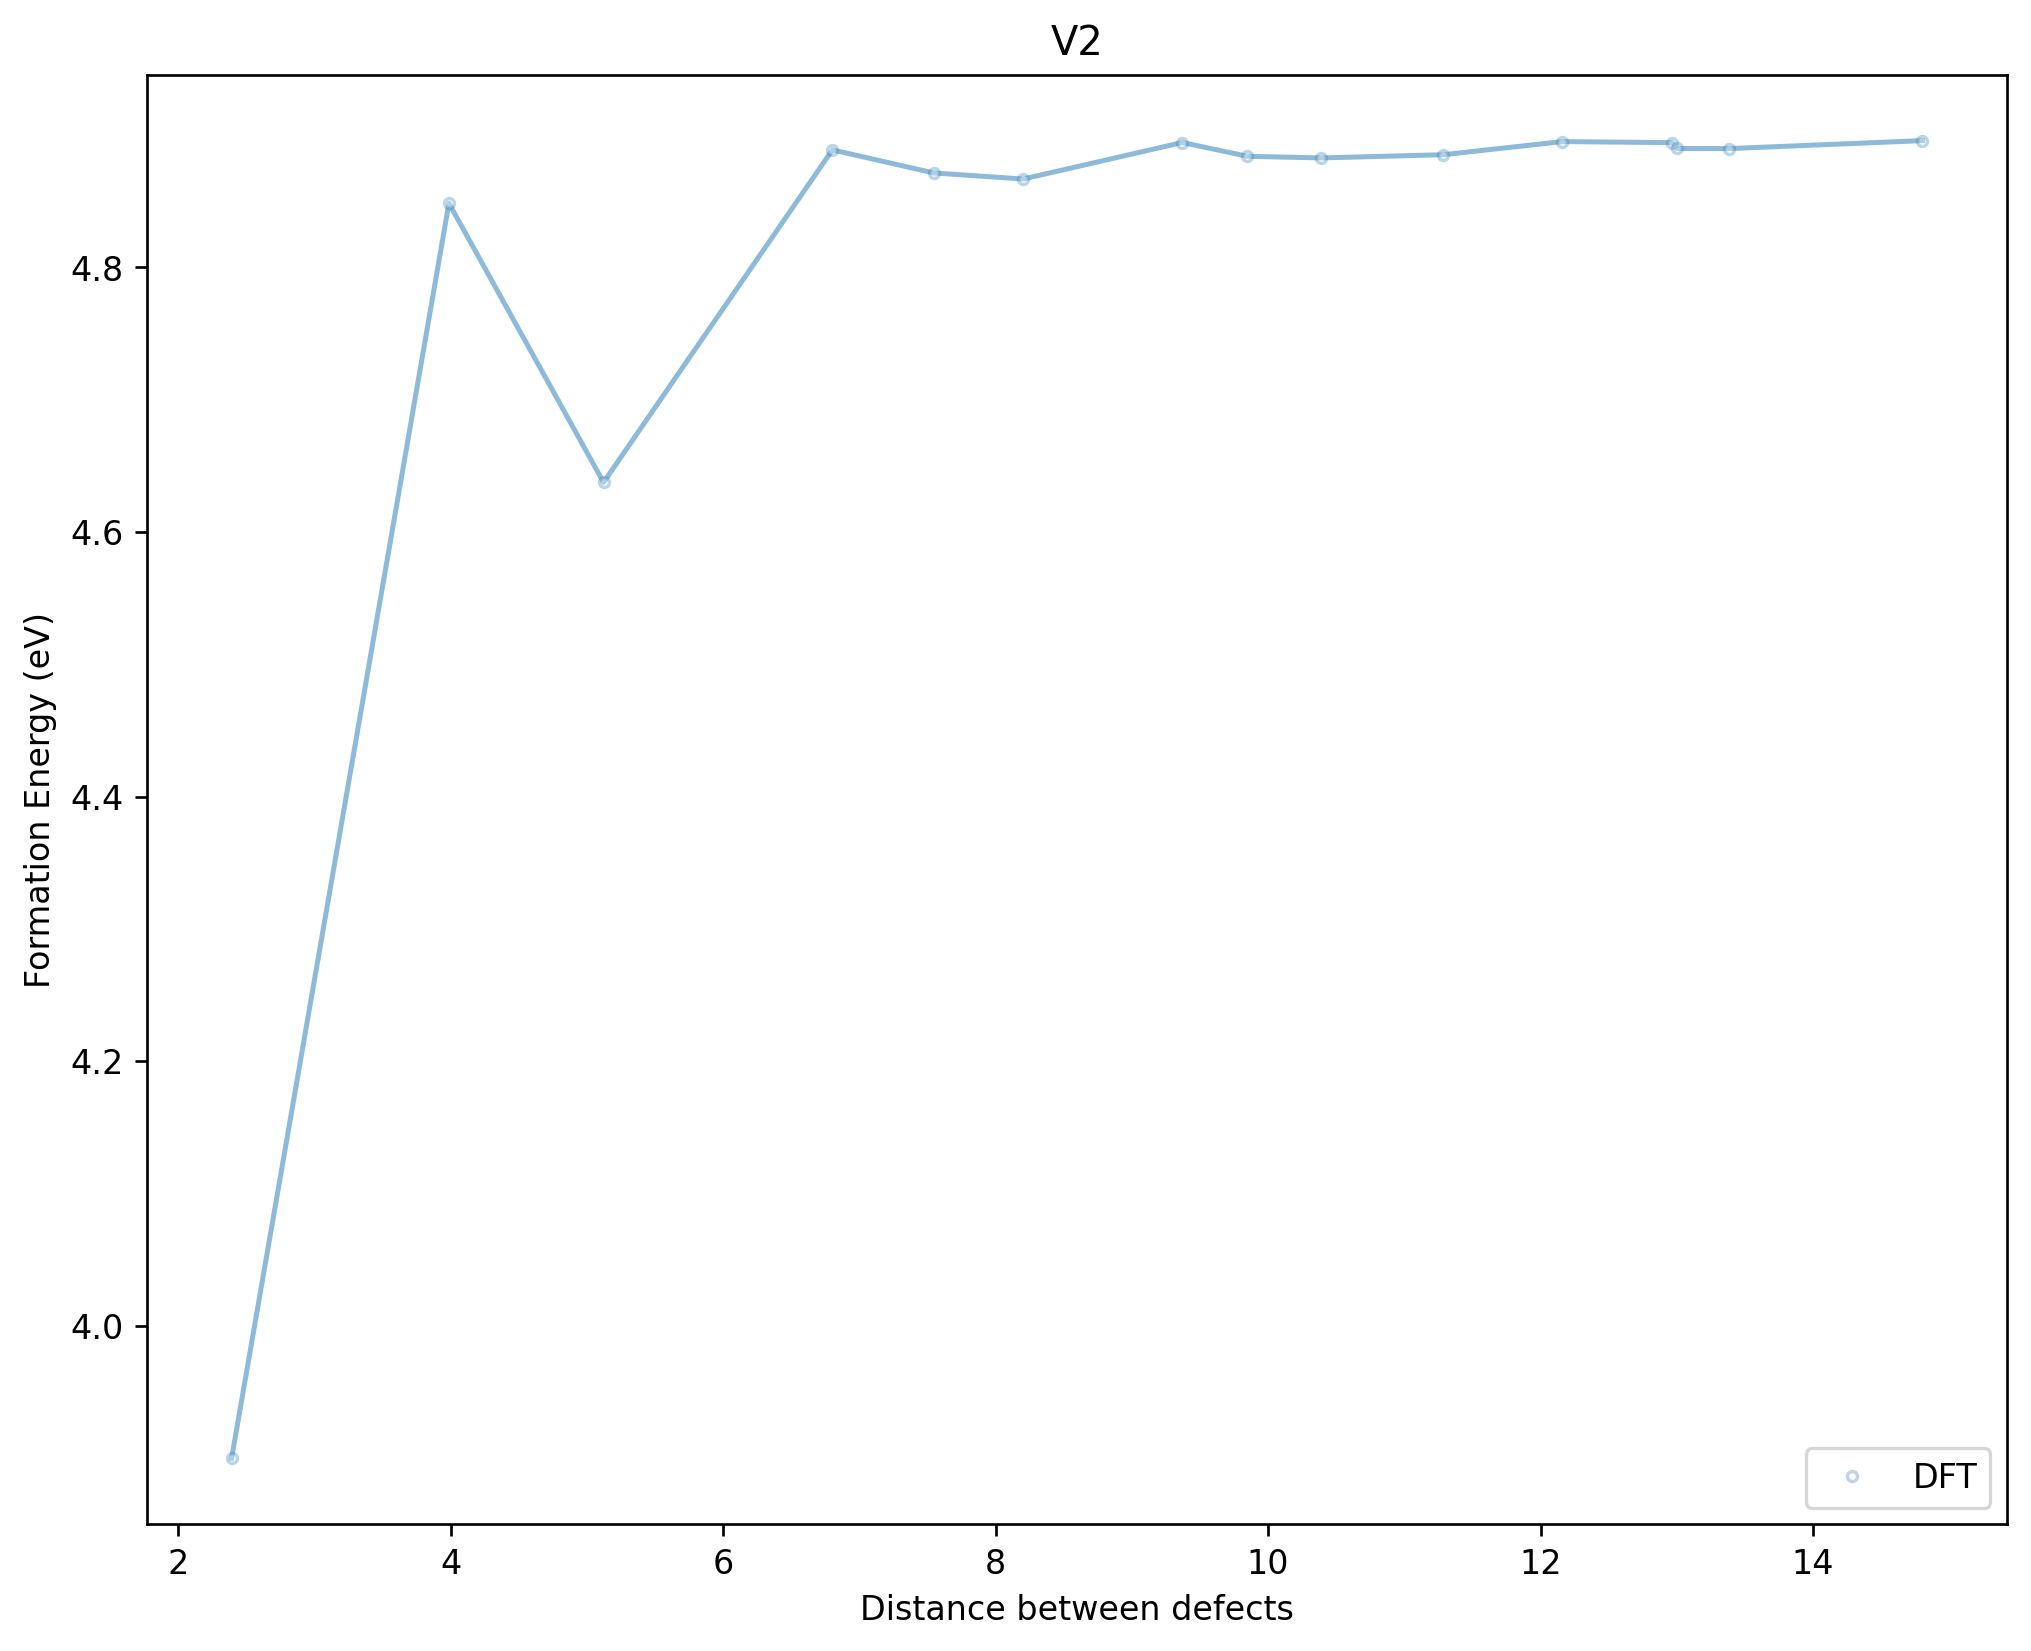

In [20]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
colors = iter(cm.tab10(np.linspace(0, 1, 6)))

for g, pred in predictions.groupby(level=0, axis=1):
    legend = pred.columns.get_level_values(0)[0]
    pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v2.index].droplevel(1).assign(v2=v2)
    if 'DFT' == g:
        plot(
            pred.v2,
            pred.formation_energy_per_site,
            legend=legend,
            color=next(colors),
            ax=ax,
        )
        break

ax.set_ylabel('Formation Energy (eV)'),
ax.set_xlabel('Distance between defects')
ax.set_title('V2')

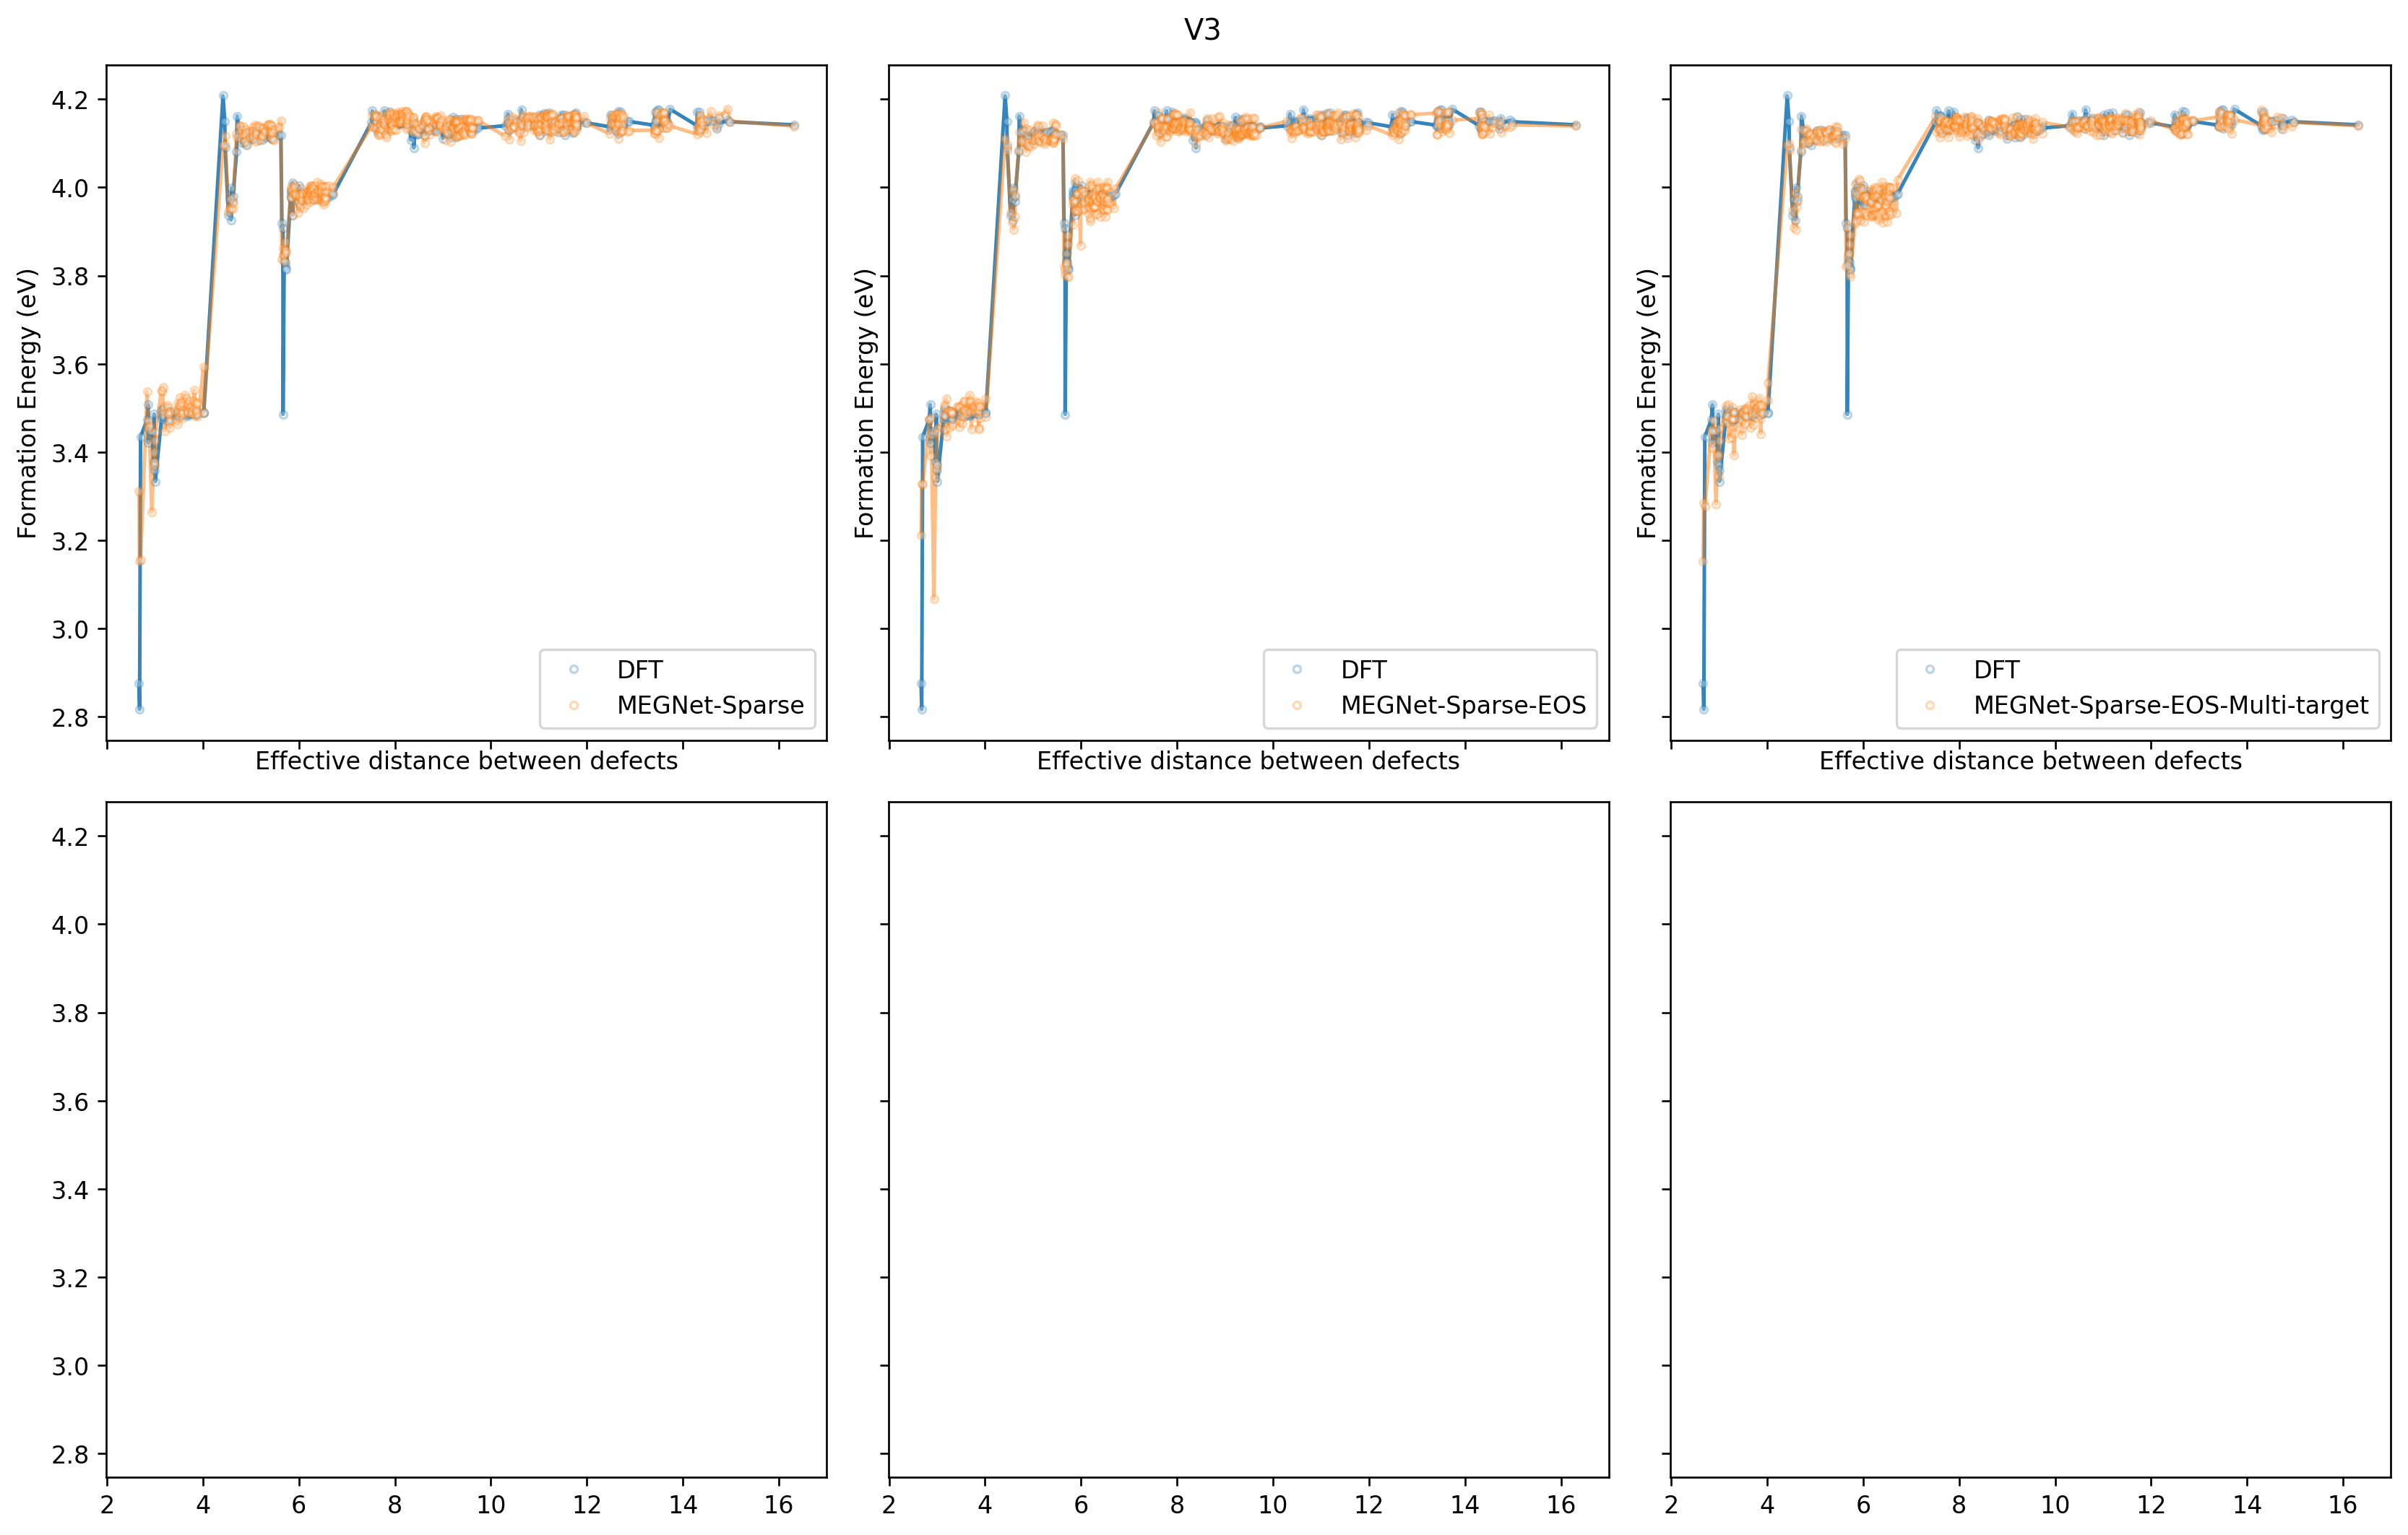

In [66]:
v3_groups, v3_dfs = list(map(list, zip(*predictions.groupby(level=0, axis=1))))
dft = predictions.loc[:, 'DFT'].loc[v3.index].droplevel(1).assign(v3=v3)
fig, axs = plt.subplots(2, 3, figsize=(14, 9), dpi=120, sharex=True, sharey=True)


for name, ax in zip(['MEGNet-Sparse', 'MEGNet-Sparse-EOS', 'MEGNet-Sparse-EOS-Multi-target'], axs.flatten()):
    colors = iter(cm.tab10(np.linspace(0, 1, 10)))
    
    pred = predictions.loc[:, name]
    # pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v3.index].droplevel(1).assign(v3=v3)

    for name, data in {'DFT': dft, name: pred}.items():
        plot(
            data.v3,
            data.formation_energy_per_site,
            legend=name,
            ax=ax,
            color=next(colors),
            alpha=0.9 if name == 'DFT' else 0.5,
        )

    ax.set_ylabel('Formation Energy (eV)'),
    ax.set_xlabel('Effective distance between defects')

fig.suptitle('V3')
fig.tight_layout()
fig.show()

Text(0.5, 1.0, 'V3')

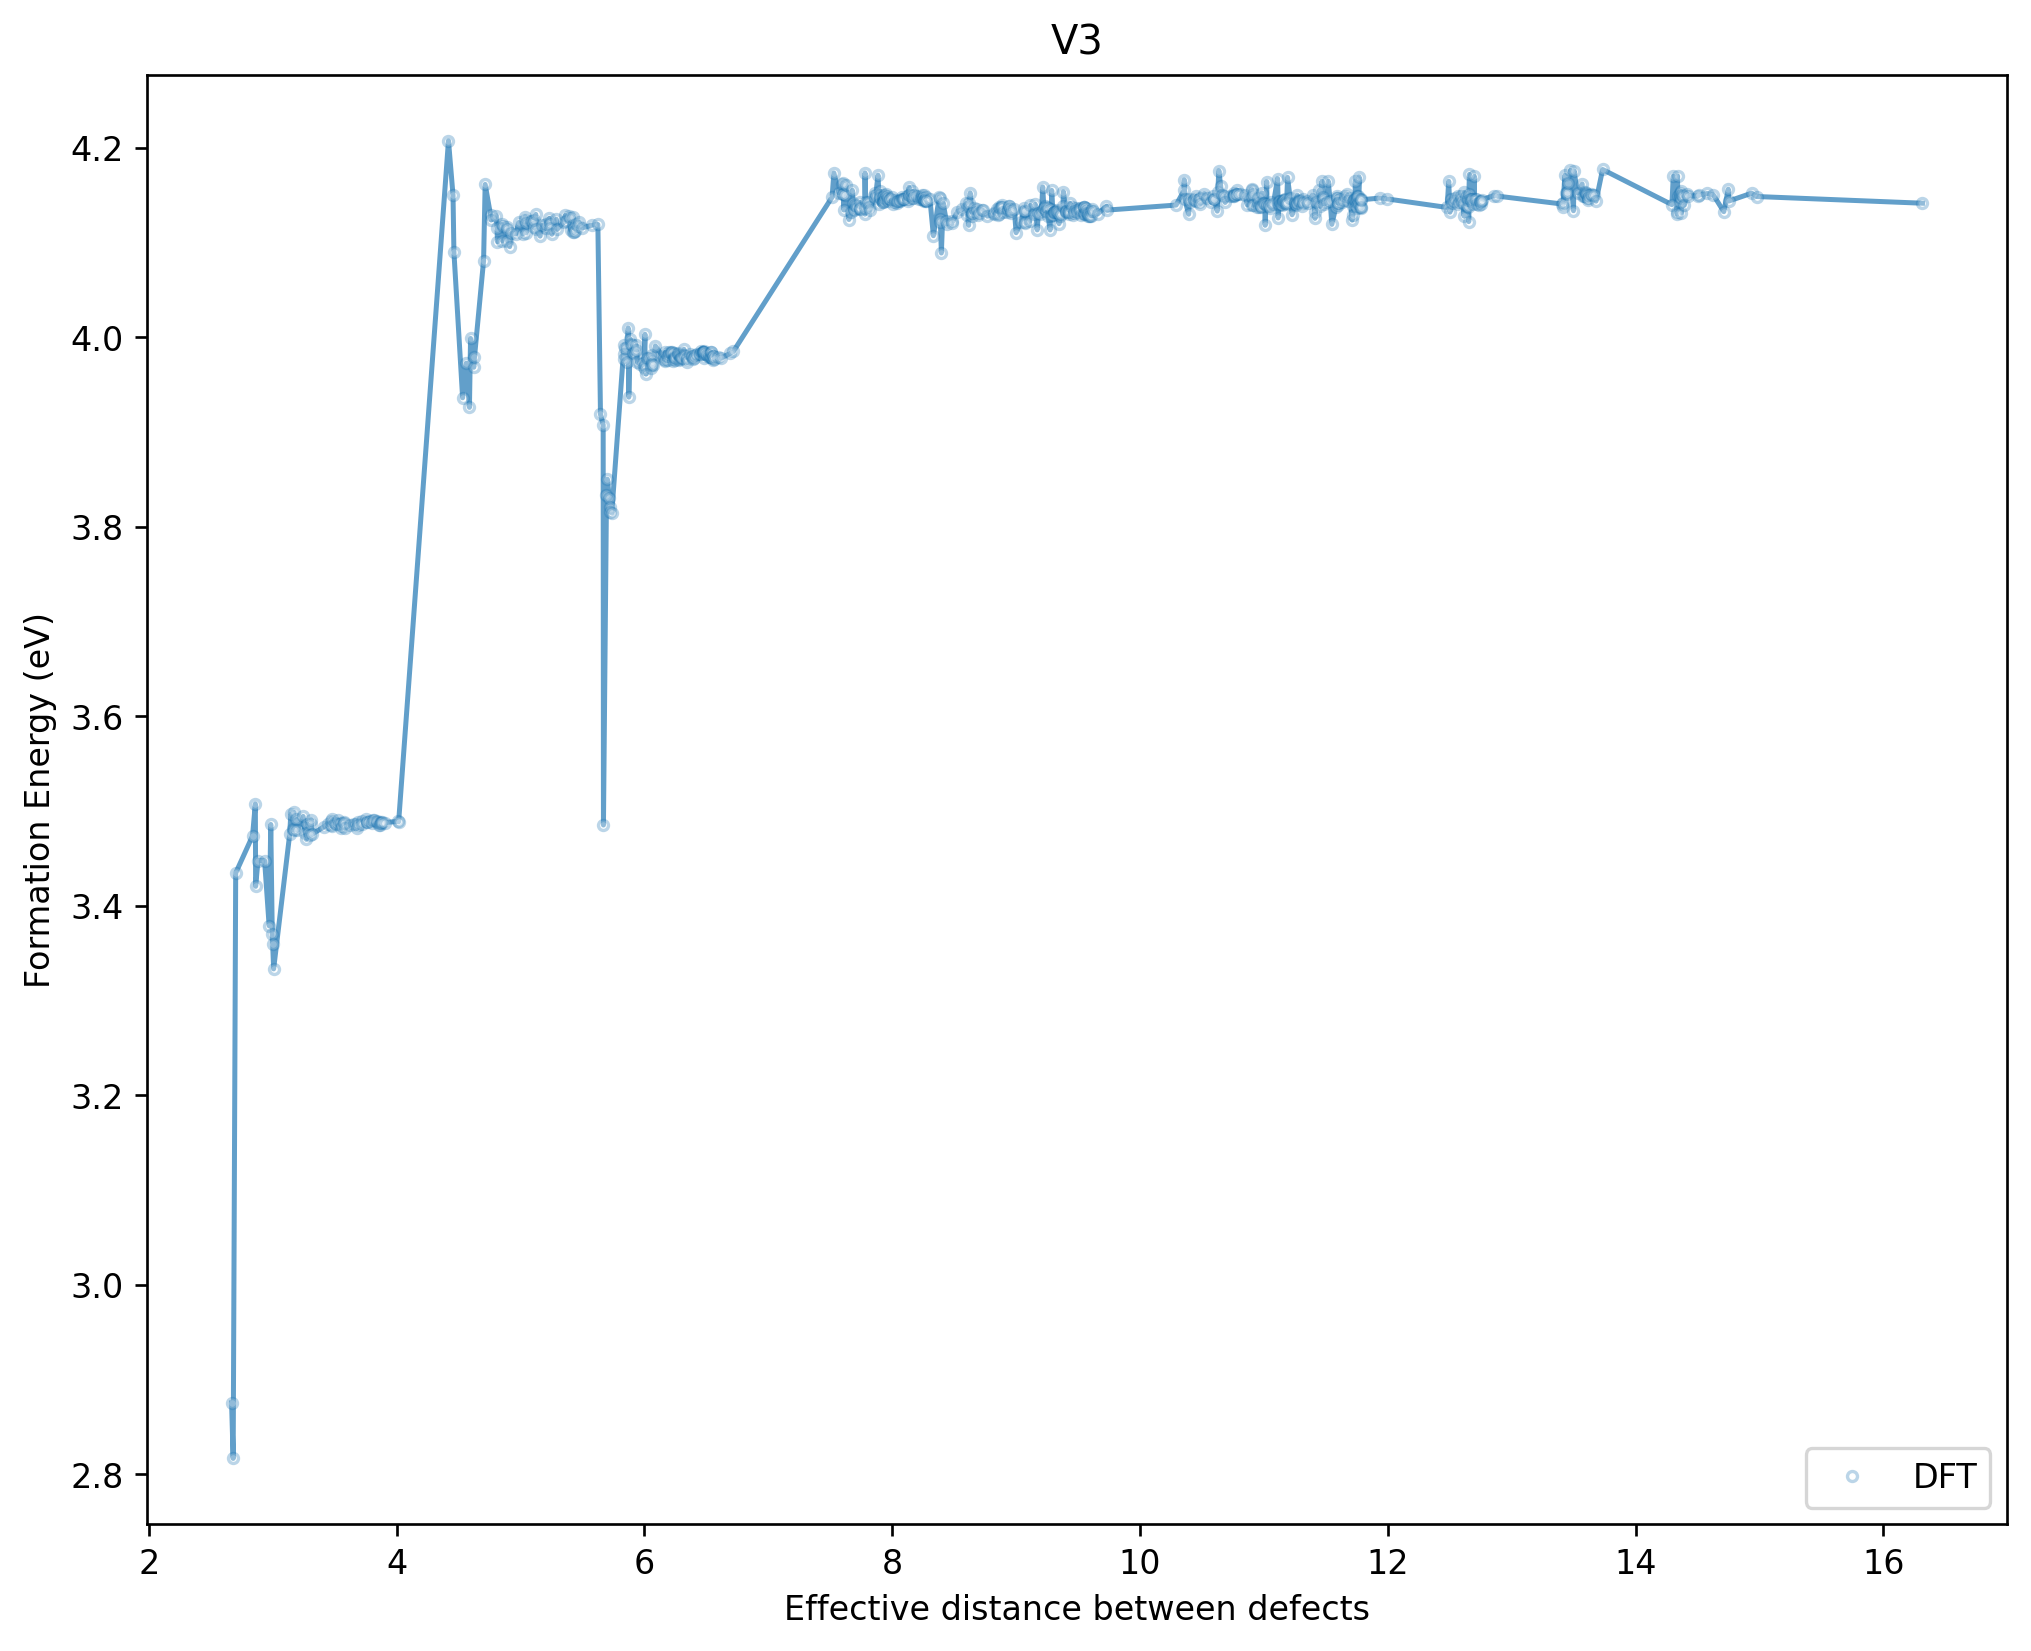

In [36]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
colors = iter(cm.tab10(np.linspace(0, 1, 6)))

for g, pred in predictions.groupby(level=0, axis=1):
    legend = pred.columns.get_level_values(0)[0]
    pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v3.index].droplevel(1).assign(v3=v3)
    if 'DFT' == g:
        plot(
            pred.v3,
            pred.formation_energy_per_site,
            legend=legend,
            ax=ax,
            color=next(colors),
            alpha=0.7,
            zorder=-1 if 'SchNet' in legend else 1
        )
        break

ax.set_ylabel('Formation Energy (eV)'),
ax.set_xlabel('Effective distance between defects')
ax.set_title('V3')

In [69]:
dft.query('v3 > 4.6 and v3 < 6 and formation_energy_per_site > 3.4 and formation_energy_per_site < 3.6')

energy  energy_per_atom  formation_energy  \
_id                                                                        
614401833ac25c70a5c6cd4f -1368.470003        -7.240582         10.455897   

                          formation_energy_per_site  band_gap    homo    lumo  \
_id                                                                             
614401833ac25c70a5c6cd4f                   3.485299    0.3098 -0.4711 -0.1613   

                          fermi_level       v3  
_id                                             
614401833ac25c70a5c6cd4f    -0.317455  5.66876

In [70]:
close = dft.query('v3 > 5.5 and v3 < 6')

In [71]:
from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms

In [72]:
close.iloc[0].name

'6141cf983ac25c70a5c6c86b'

In [73]:
close.__len__() //4

7

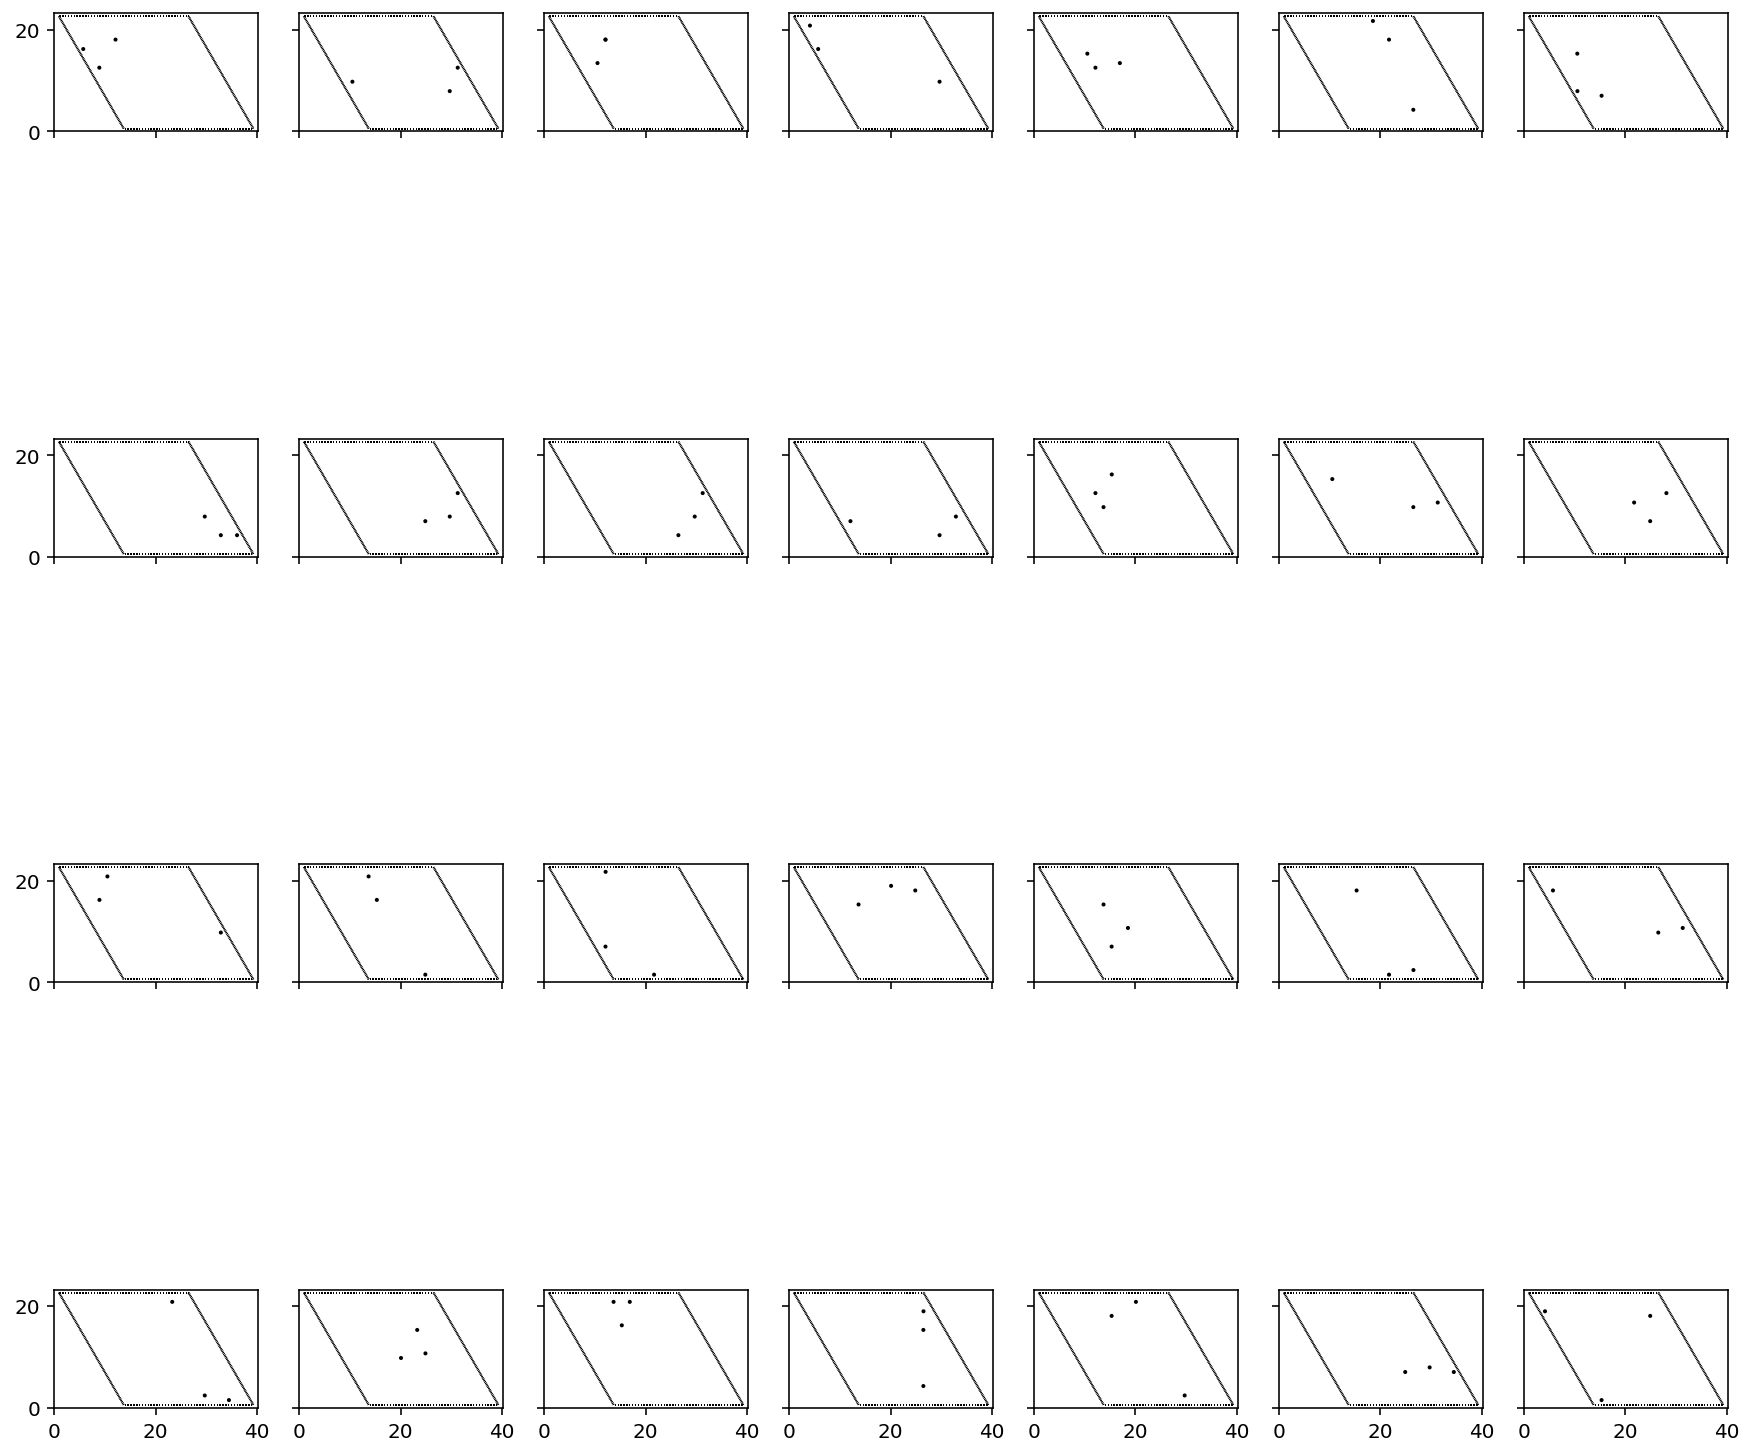

In [81]:
fig, axs = plt.subplots(4, len(close)//4, figsize=(15, 15), sharex=True, sharey=True)

for i, ax in enumerate(axs.flatten()):
    plot_atoms(AseAtomsAdaptor().get_atoms(structures.loc[close.iloc[i].name].defect_representation), radii=0.99, ax=ax)
    
# fig.tight_layout()

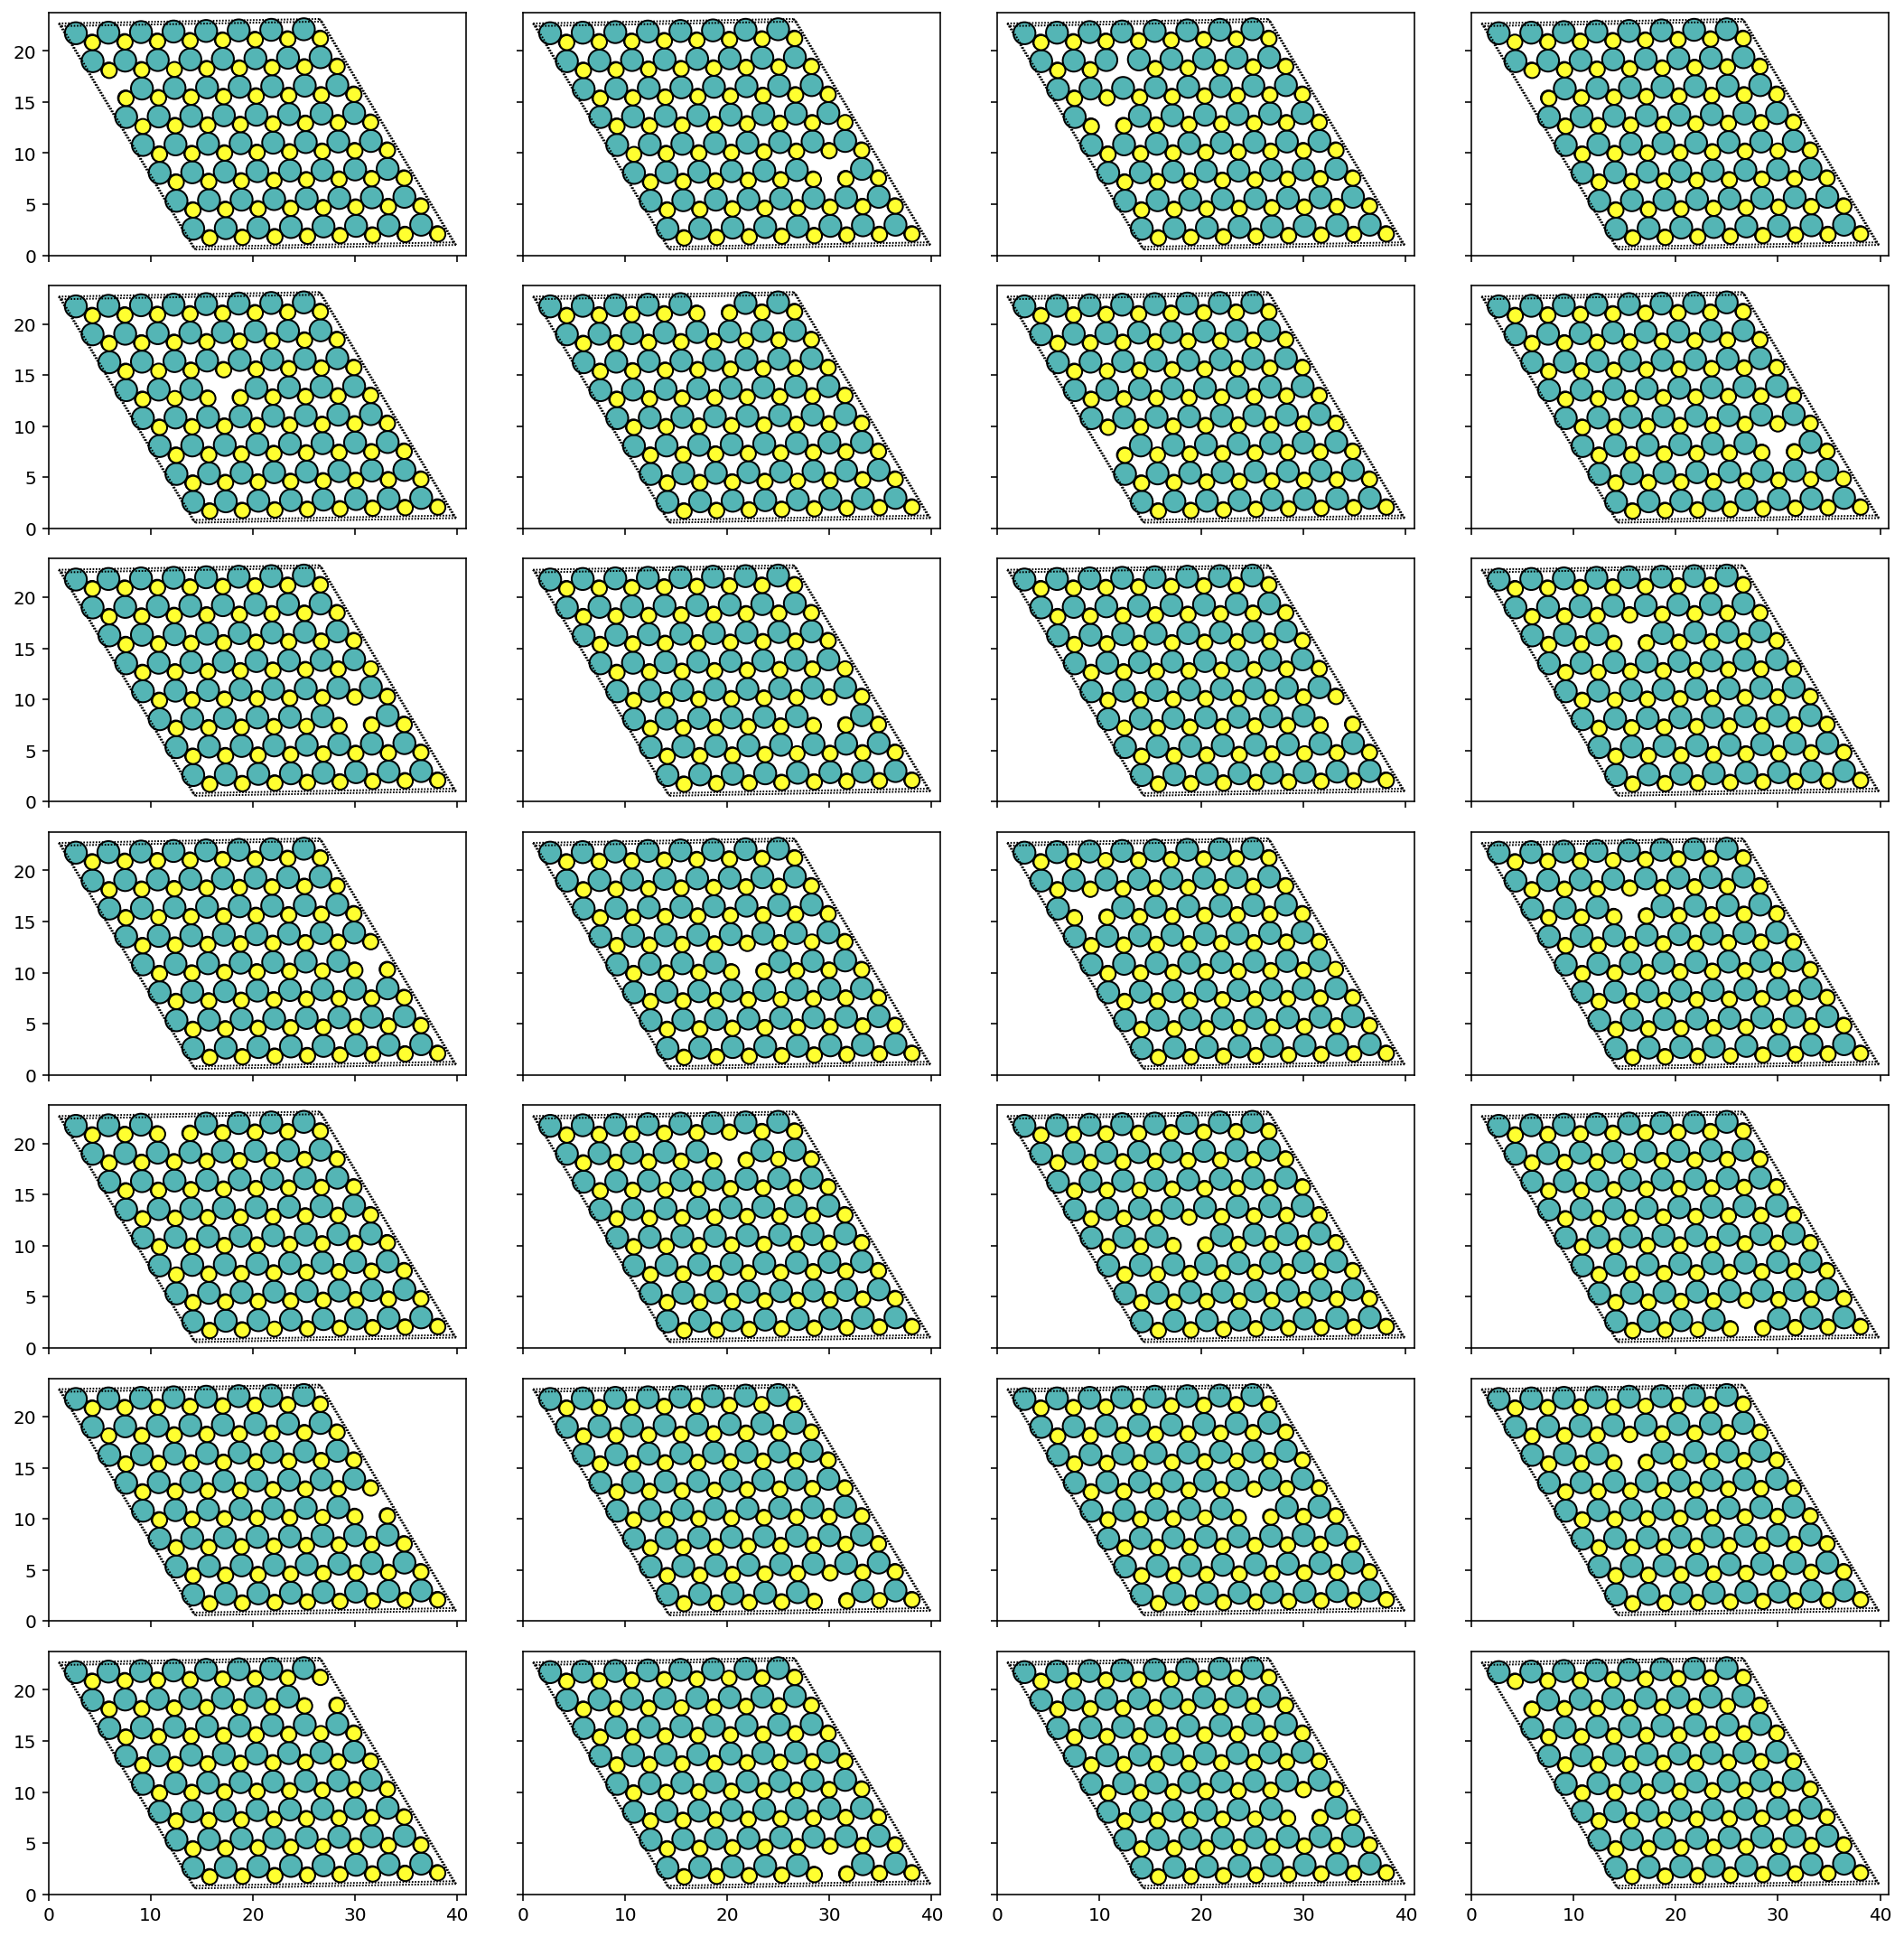

In [82]:
fig, axs = plt.subplots(len(close)//4, 4, figsize=(15, 15), sharex=True, sharey=True)

for i, ax in enumerate(axs.flatten()):
    plot_atoms(AseAtomsAdaptor().get_atoms(structures.loc[close.iloc[i].name].initial_structure), radii=0.7, ax=ax, rotation=('1x,1y,1z'))
    
fig.tight_layout()

In [43]:
plotter(structures.loc['614401833ac25c70a5c6cd4f'].defect_representation)

# Energy correlation

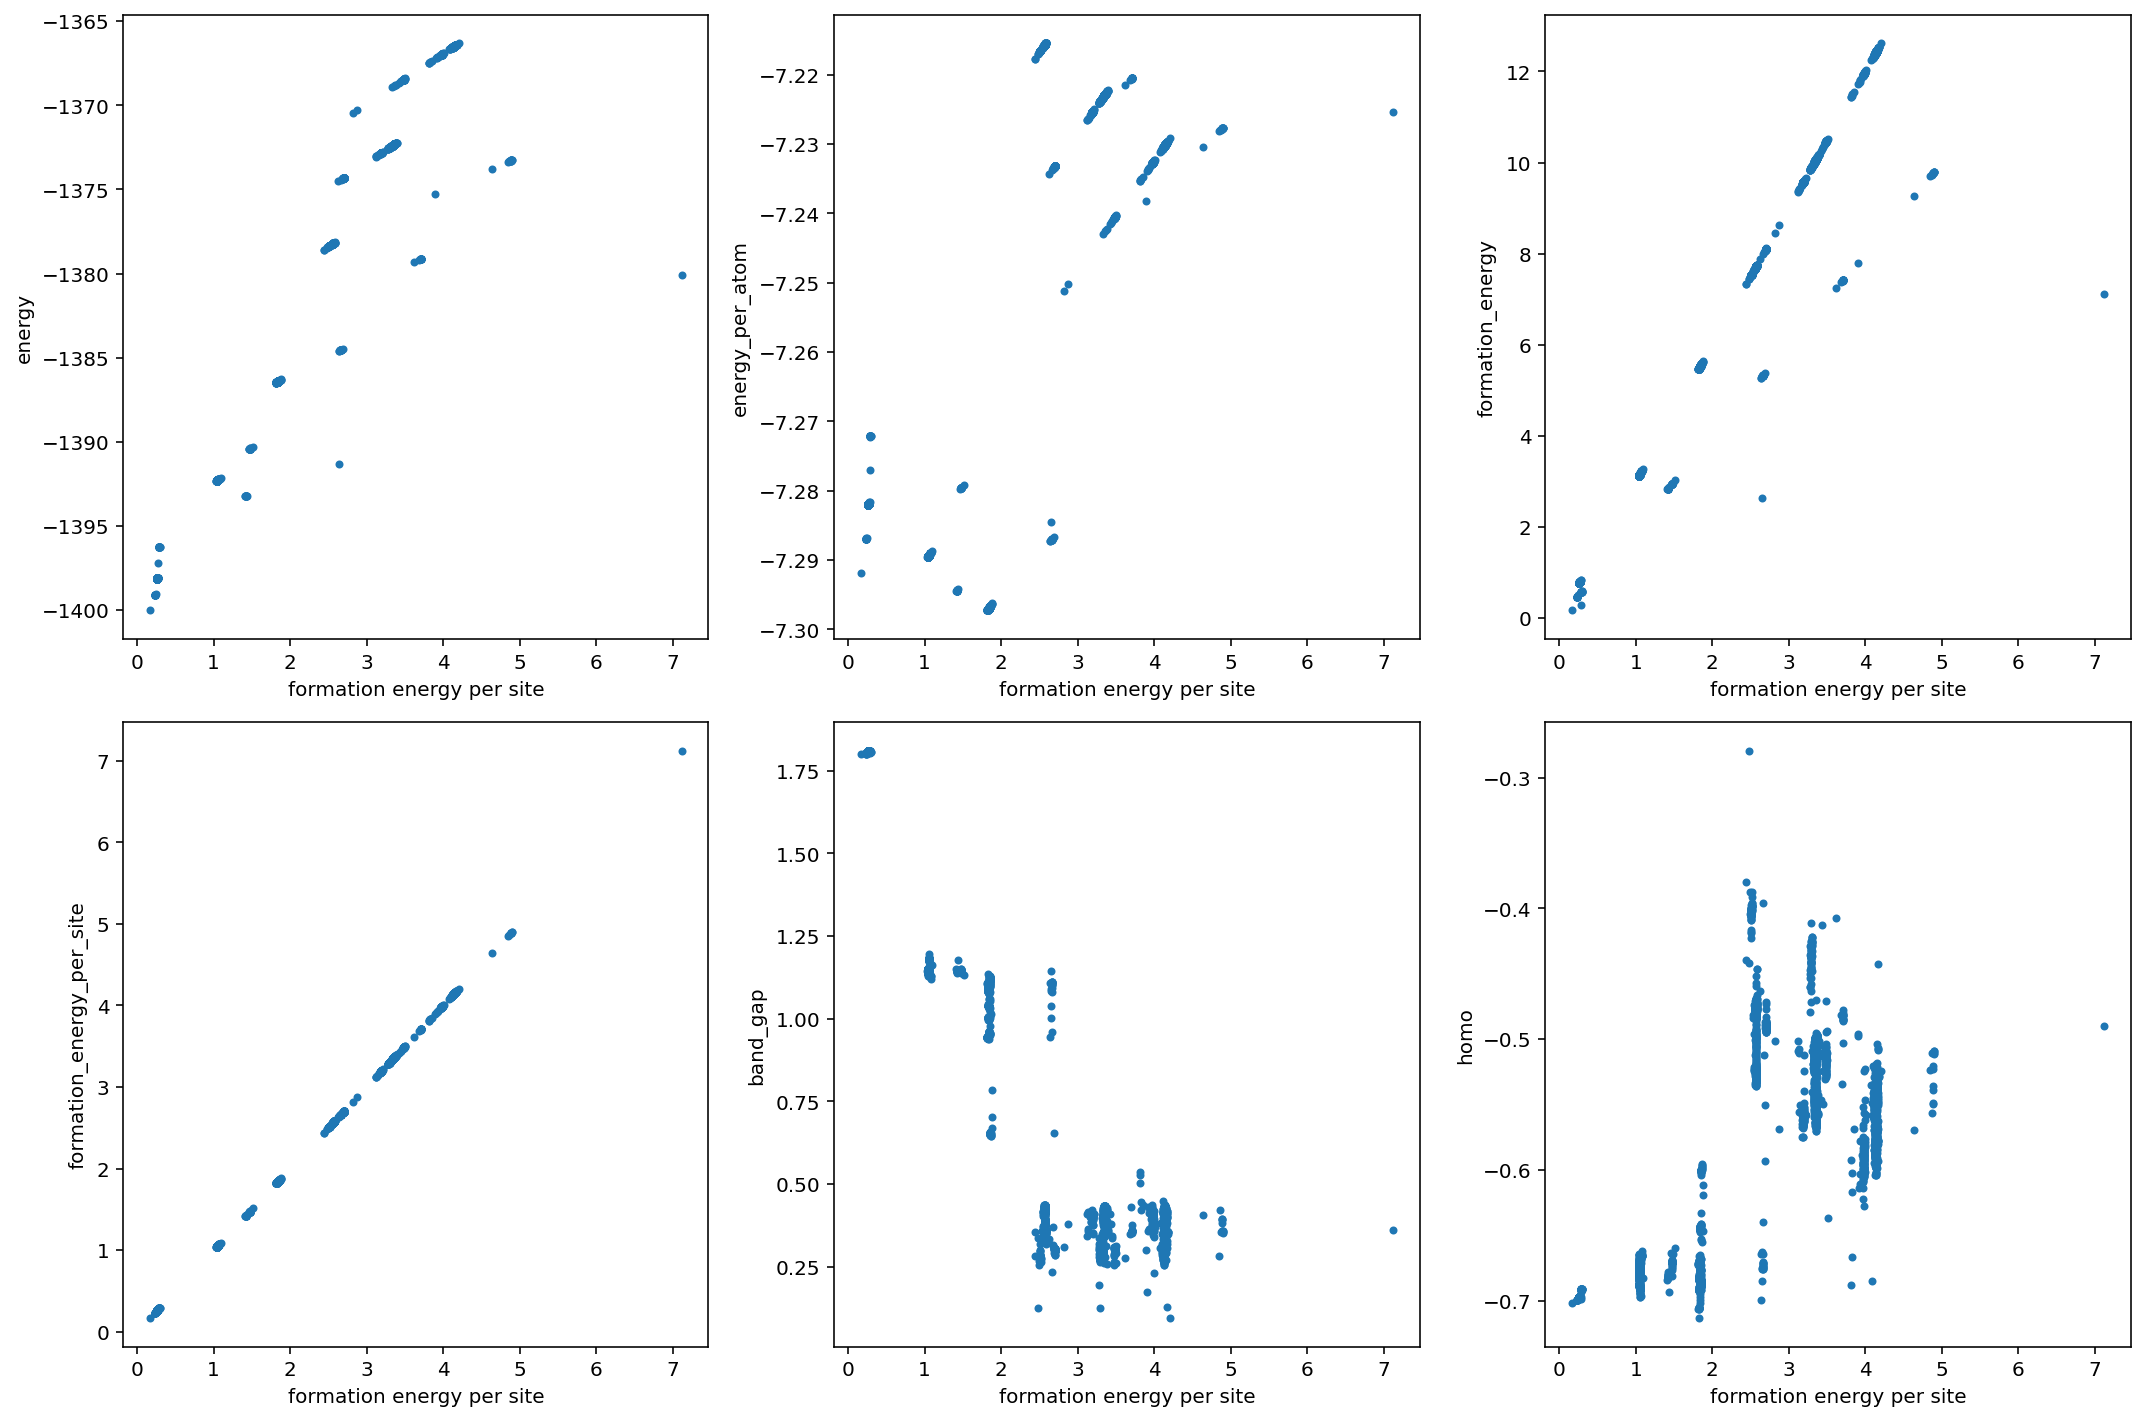

In [106]:
form_e = structures['formation_energy_per_site']
args_form_e = np.argsort(form_e)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for e, ax in zip(['energy',	'energy_per_atom',	'formation_energy',	'formation_energy_per_site', 'band_gap', 'homo', 'lumo', 'fermi_level'],
             axs.flatten()):
    ax.plot(form_e[args_form_e], structures[e][args_form_e], '.')
    ax.set_ylabel(e)
    ax.set_xlabel('formation energy per site')
fig.tight_layout()


In [110]:
import seaborn as sns


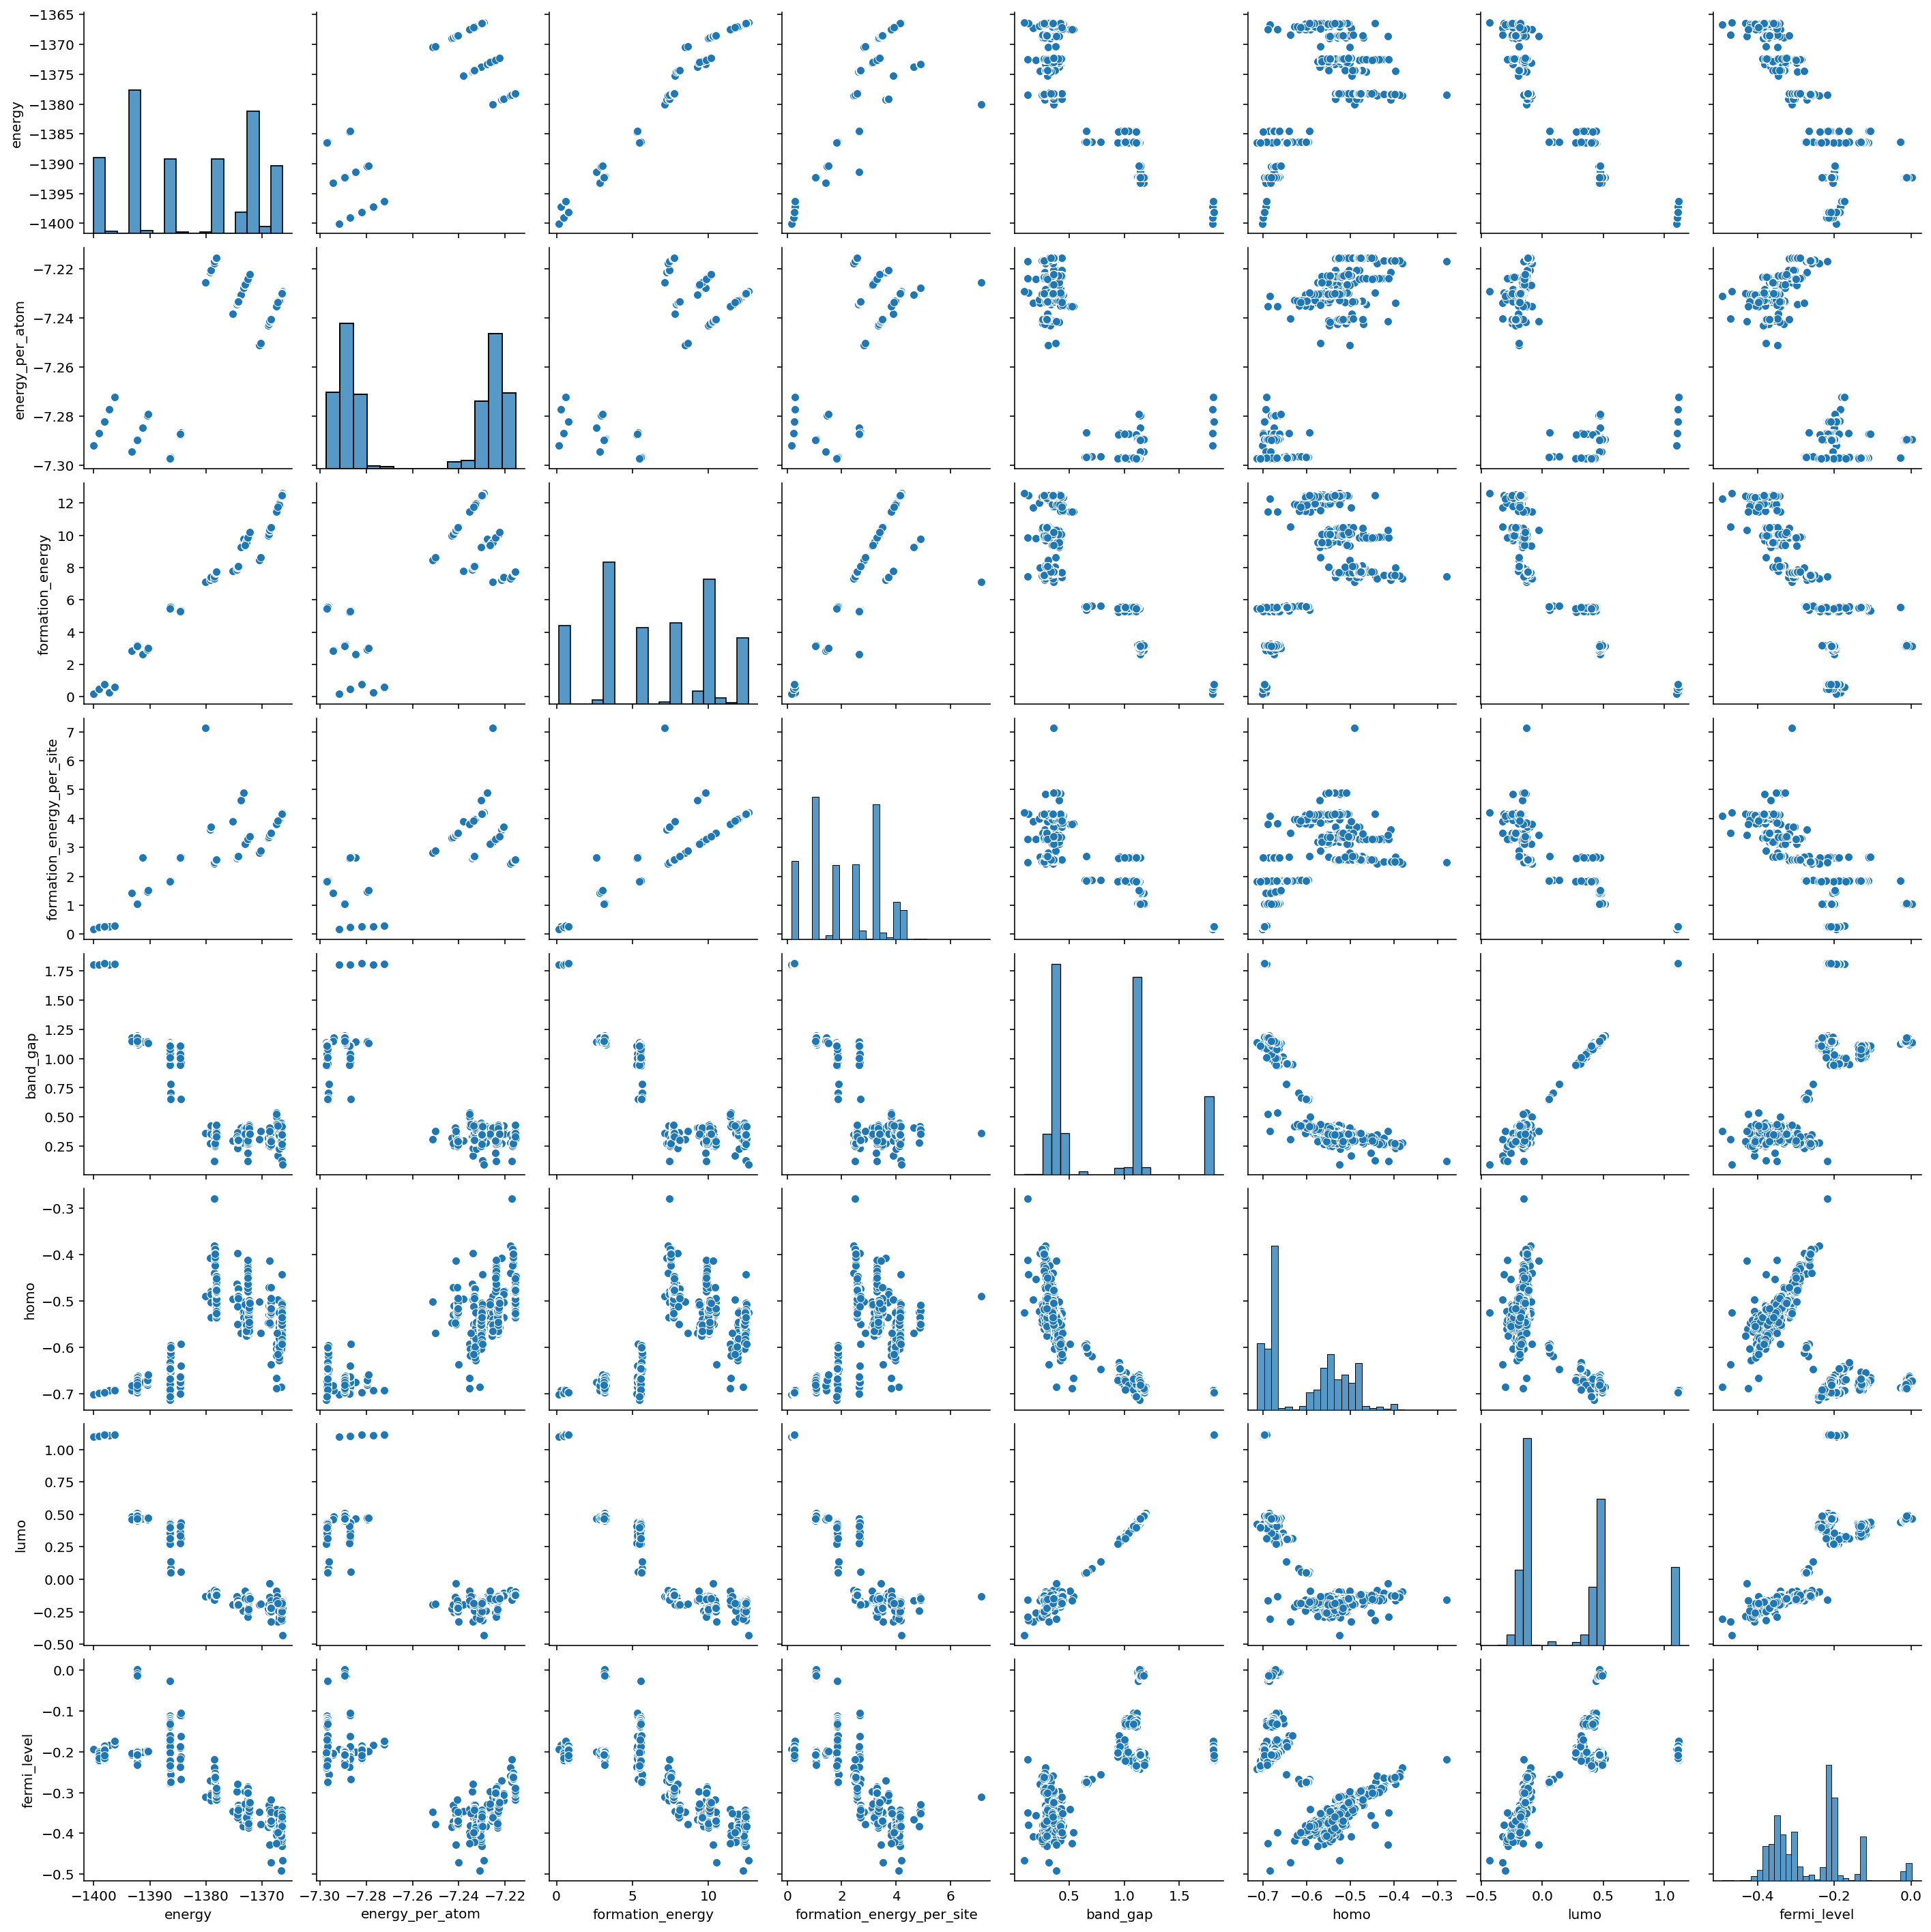

In [114]:
sns.pairplot(structures[['energy',	'energy_per_atom',	'formation_energy',	'formation_energy_per_site', 'band_gap', 'homo', 'lumo', 'fermi_level']])
plt.savefig('pairplot_e.jpg', dpi=300)